In this script is the data smoothen after the PC are constructed 

In [1]:
# importing tools 
import s3fs
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt 
import math
#for removing warnings
import warnings

In [3]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}/*'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, combine='by_coords',compat='override')
    # rename variabel
    dset = dset.rename({'__xarray_dataarray_variable__' : 'vel'})
    return dset

In [4]:
dset = open_s3fs('PC-data')
dset

<xarray.Dataset>
Dimensions:        (depth: 75, x: 1580, y: 1801)
Coordinates:
  * depth          (depth) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
Dimensions without coordinates: x, y
Data variables:
    vel            (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    mbathy         (y, x) int16 dask.array<chunksize=(1801, 1580), meta=np.ndarray>
    vomecrty       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>
    vozocrtx       (depth, y, x) float32 dask.array<chunksize=(75, 1801, 1580), meta=np.ndarray>

In [5]:
# Smoothen data, over every tenth point in both x and y direction, for all the data
vvar = dset.vomecrty.isel(y=slice(900,1800), x=slice(200,1400))
uvar = dset.vozocrtx.isel(y=slice(900,1800), x=slice(200,1400))
uv = dset.vel.isel(y=slice(900,1800), x=slice(200,1400))

In [6]:
# Getting the bottom velocity 
d = dset.mbathy[900:1800,200:1400].values-1
d[d==-1] = 0

d = xr.DataArray(d, dims=['y','x'])

uvar_b = uvar.isel(depth=d)
vvar_b = vvar.isel(depth=d)
uv_b = uv.isel(depth=d)

In [9]:
uv_b

<xarray.DataArray 'vel' (y: 900, x: 1200)>
dask.array<reshape, shape=(900, 1200), dtype=float32, chunksize=(900, 1200), chunktype=numpy.ndarray>
Coordinates:
    depth          (y, x) float64 0.5058 0.5058 0.5058 ... 0.5058 0.5058 0.5058
    time_centered  object ...
    time_counter   object ...
    nav_lat        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(900, 1200), meta=np.ndarray>
Dimensions without coordinates: y, x

The bottom current when the data have been smoothened before constructing the PC

In [13]:
# Making the covmatrix and finding the eigenvalues and eigenvectors
# list of all the points for the PC-crosses

# List of x,y elements
dx = 20
dy = 20

jmax, imax = uv_b.shape
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

PC11 = []
PC12 = []
PC21 = []
PC22 = []
y = []
x = []

#ellipser:
expr = []
eypr = []
exmr = []
eymr = []

indx =0

# To get the loop to run faster 
uvy = np.array(uv_b.y.values)
uvx = np.array(uv_b.x.values)


uvarb = np.array(uvar_b.values)
vvarb = np.array(vvar_b.values)
uvb = np.array(uv_b.values)

for i in i_list:
    for j in j_list:
        covm = np.array([[uvarb[j,i],uvb[j,i]],
            [uvb[j,i],vvarb[j,i]]],dtype=float)
        if np.isnan(covm).any():
            continue
        else:
            # Find and sort eigenvalues and eigenvectors into descending order
            values, vectors = np.linalg.eig(covm)
            order = values.argsort()[::-1]
            values, vectors = values[order], vectors[:, order]
            
            # vanlig PC kryss:
            PC11.append(vectors[0,0]*np.sqrt(values[0]))
            PC12.append(vectors[1,0]*np.sqrt(values[0]))
            PC21.append(vectors[0,1]*np.sqrt(values[1]))
            PC22.append(vectors[1,1]*np.sqrt(values[1]))
            y.append(uvy[j])
            x.append(uvx[i])
            
            # ellipser :
            major = np.sqrt(values[0])
            minor = np.sqrt(values[1])

            # The anti-clockwise angle to rotate our ellipse by 
            vx, vy = vectors[:,0][0], vectors[:,0][1]
            theta = np.arctan2(vy, vx)

            scal = 0.5

            b=major/scal
            d=minor/scal
            ex = np.linspace(-b,b, 50)
            eyp=d*(1-(ex/b)**2)
            eym=-d*(1 - (ex/b)**2)
            
            expr_i=ex*math.sin(theta) - eyp*math.cos(theta)
            #expr_i=expr_i/math.cos(y*2*pi/360)                   # correct distances for cart. proj.
            expr.append(expr_i)
            eypr_i=ex*math.cos(theta) + eyp*math.sin(theta)
            eypr.append(eypr_i)
            exmr_i=ex*math.sin(theta) - eym*math.cos(theta)
            #exmr_i=exmr_i/math.cos(y*2*pi/360)
            exmr.append(exmr_i)
            eymr_i=ex*math.cos(theta) + eym*math.sin(theta)
            eymr.append(eymr_i)

            indx = indx + 1


<ipython-input-13-3fa91a62a93e>:69: RuntimeWarning: invalid value encountered in true_divide
  eyp=d*(1-(ex/b)**2)
<ipython-input-13-3fa91a62a93e>:70: RuntimeWarning: invalid value encountered in true_divide
  eym=-d*(1 - (ex/b)**2)


In [20]:
# converting to np.arrays
PC11 = np.array(PC11,dtype=float)
PC12 = np.array(PC12,dtype=float)
PC21 = np.array(PC21,dtype=float)
PC22 = np.array(PC22,dtype=float)
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)
#ellipse
xe = np.array(xe,dtype=float)
ye = np.array(ye,dtype=float)
expr = np.array(expr, dtype=float)
eypr = np.array(eypr, dtype=float)
exmr = np.array(exmr, dtype=float)
eymr = np.array(eymr, dtype=float)

In [8]:
print(eym)
print(eyp)

[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [28]:
ex

array([-0.042855  , -0.04110581, -0.03935663, -0.03760745, -0.03585826,
       -0.03410908, -0.0323599 , -0.03061071, -0.02886153, -0.02711235,
       -0.02536316, -0.02361398, -0.02186479, -0.02011561, -0.01836643,
       -0.01661724, -0.01486806, -0.01311888, -0.01136969, -0.00962051,
       -0.00787133, -0.00612214, -0.00437296, -0.00262378, -0.00087459,
        0.00087459,  0.00262378,  0.00437296,  0.00612214,  0.00787133,
        0.00962051,  0.01136969,  0.01311888,  0.01486806,  0.01661724,
        0.01836643,  0.02011561,  0.02186479,  0.02361398,  0.02536316,
        0.02711235,  0.02886153,  0.03061071,  0.0323599 ,  0.03410908,
        0.03585826,  0.03760745,  0.03935663,  0.04110581,  0.042855  ])

In [52]:
xe = np.zeros_like(expr)
ye = np.zeros_like(eypr)

for i in range(len(expr)):
    for j in range(len(expr[0])):
        xe[i,j]=x[i]
        ye[i,j]=y[i]


(1630,)
(1630, 50)
(1630, 50)
(50,)
1630
50
[[   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 ...
 [1180. 1180. 1180. ... 1180. 1180. 1180.]
 [1180. 1180. 1180. ... 1180. 1180. 1180.]
 [1180. 1180. 1180. ... 1180. 1180. 1180.]]


NameError: name 'PC11_s' is not defined

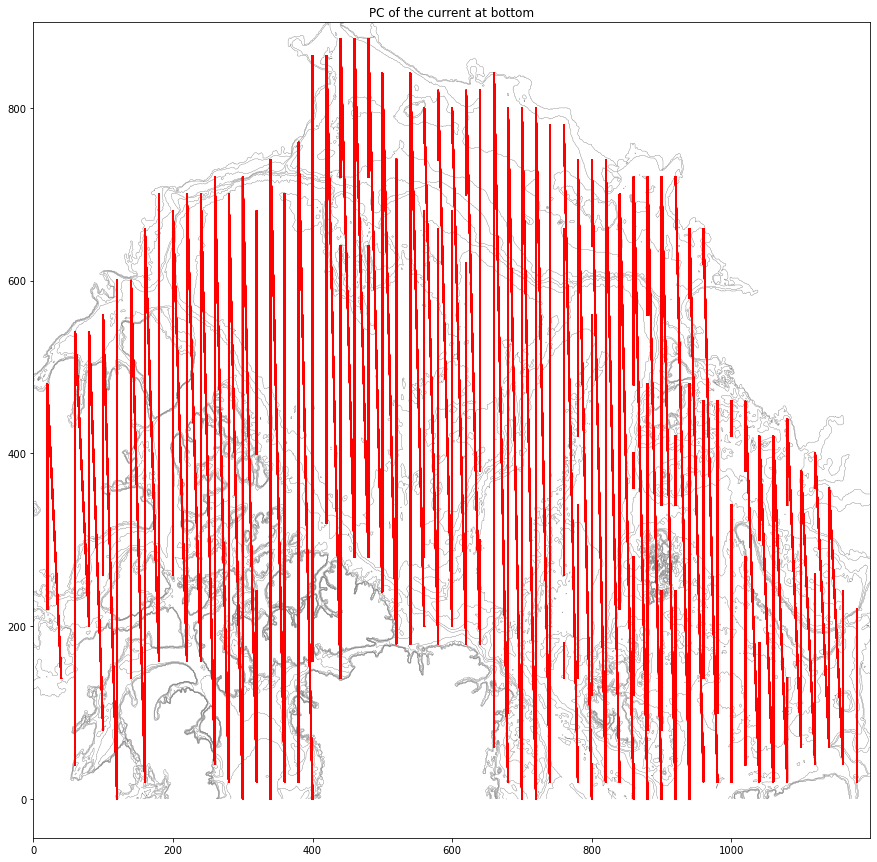

In [60]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
n = 2
plt.title(f'PC of the current at bottom')
ax.contour(dset.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

ax.plot((expr[::n]+xe[::n]),(eypr[::n]+ye[::n]),'r',(exmr[::2]+xe[::2]),(eymr[::n]+ye[::n]),'r')

ax.quiver( x[::2], y[::2], PC11[::2], PC12[::2], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver(x[::2], y[::2], -PC11[::2], -PC12[::2],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::2], y[::2], PC21[::2], PC22[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::2], y[::2], -PC21[::2], -PC22[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.set_aspect('equal')
plt.show()

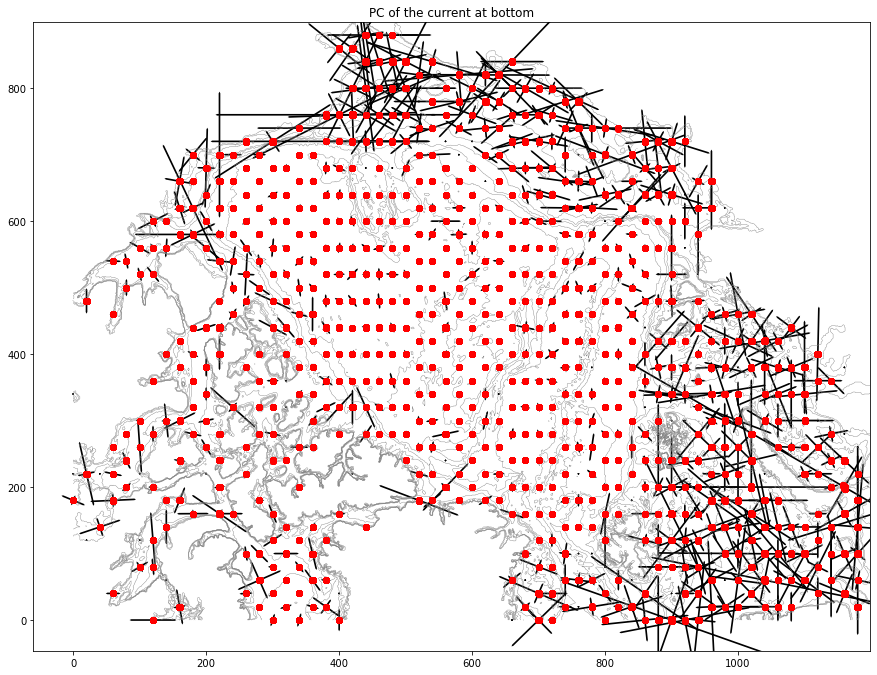

In [63]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
n = 2
plt.title(f'PC of the current at bottom')
ax.contour(dset.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

ax.plot((expr[::n]+xe[::n]),(eypr[::n]+ye[::n]),'ro',(exmr[::2]+xe[::2]),(eymr[::n]+ye[::n]),'ro')

ax.quiver( x[::2], y[::2], PC11[::2], PC12[::2], 
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver(x[::2], y[::2], -PC11[::2], -PC12[::2],
    #color='r',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::2], y[::2], PC21[::2], PC22[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.quiver( x[::2], y[::2], -PC21[::2], -PC22[::2],
    #color='b',
    headwidth=1,
    headlength=1,
    width=0.002,
    scale=0.5)
ax.set_aspect('equal')
plt.show()

In [ ]:
# Making the covmatrix and finding the eigenvalues and eigenvectors
# list of all the points for the PC-crosses

# List of x,y elements
dx = 20
dy = 20

jmax, imax = uv_b.shape
i_list = np.arange(0,imax,dx)
j_list = np.arange(0,jmax,dy)

PC11 = []
PC12 = []
PC21 = []
PC22 = []
y = []
x = []

#ellipser:
expr = []
eypr = []
exmr = []
eymr = []

indx =0

# To get the loop to run faster 
uvy = np.array(uv_b.y.values)
uvx = np.array(uv_b.x.values)


uvarb = np.array(uvar_b.values)
vvarb = np.array(vvar_b.values)
uvb = np.array(uv_b.values)

for i in i_list:
    for j in j_list:
        covm = np.array([[uvarb[j,i],uvb[j,i]],
            [uvb[j,i],vvarb[j,i]]],dtype=float)
        if np.isnan(covm).any():
            continue
        else:
            # Find and sort eigenvalues and eigenvectors into descending order
            values, vectors = np.linalg.eig(covm)
            order = values.argsort()[::-1]
            values, vectors = values[order], vectors[:, order]
            
            # ellipser :
            major = np.sqrt(values[0])
            minor = np.sqrt(values[1])

            # The anti-clockwise angle to rotate our ellipse by 
            vx, vy = vectors[:,0][0], vectors[:,0][1]
            theta = np.arctan2(vy, vx)

            scal = 0.5

            b=major/scal
            d=minor/scal
            ex = np.linspace(-b,b, 50)
            eyp=d*(1-(ex/b)**2)
            eym=-d*(1 - (ex/b)**2)
            
            expr_i=ex*math.sin(theta) - eyp*math.cos(theta)
            expr_i=expr_i/(math.cos(uvy[j]*2*math.pi/360))                  # correct distances for cart. proj.
            expr.append(expr_i)
            
            eypr_i=ex*math.cos(theta) + eyp*math.sin(theta)
            eypr.append(eypr_i)
            
            exmr_i=ex*math.sin(theta) - eym*math.cos(theta)
            exmr_i=exmr_i/(math.cos(uvy[j]*2*math.pi/360))
            exmr.append(exmr_i)
            
            eymr_i=ex*math.cos(theta) + eym*math.sin(theta)
            eymr.append(eymr_i)

            indx = indx + 1

xe = np.zeros_like(expr)
ye = np.zeros_like(eypr)

for i in range(len(expr)):
    for j in range(len(expr[0])):
        xe[i,j]=x[i]
        ye[i,j]=y[i]
        
# converting to np.arrays
y = np.array(y,dtype=float)
x = np.array(x,dtype=float)
#ellipse
expr = np.array(expr, dtype=float)
eypr = np.array(eypr, dtype=float)
exmr = np.array(exmr, dtype=float)
eymr = np.array(eymr, dtype=float)

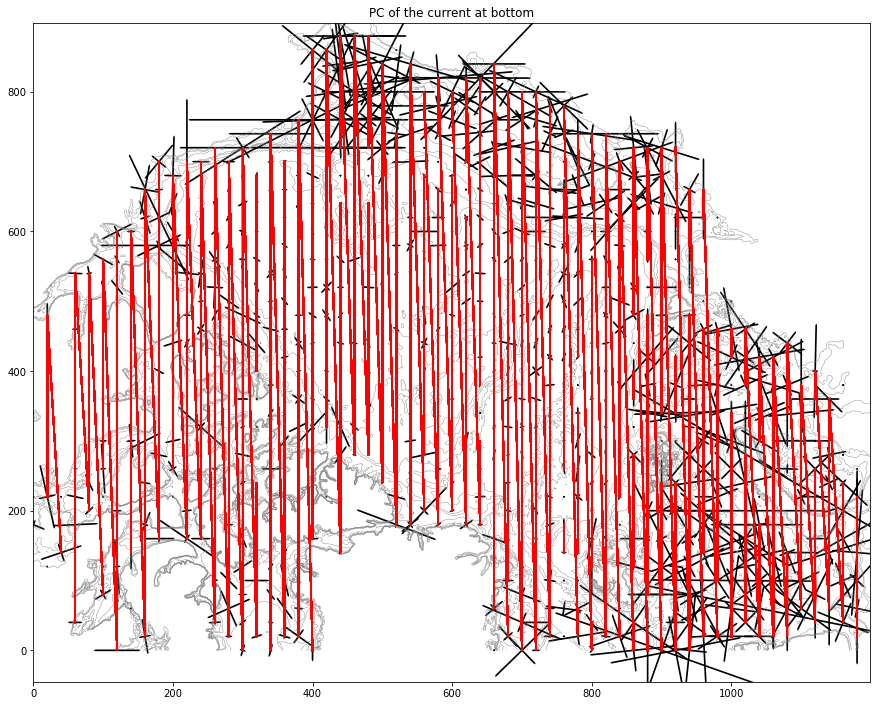

In [70]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
n = 2
plt.title(f'PC of the current at bottom')
ax.contour(dset.mbathy[900:1800,200:1400], colors='grey',levels=8, linewidths=0.4)

ax.plot((expr[::n]+xe[::n]),(eypr[::n]+ye[::n]),'r',(exmr[::2]+xe[::2]),(eymr[::n]+ye[::n]),'r')

ax.set_aspect('equal')
plt.show()